# Principle Component Analysis using methods from sklearn

In [1]:
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt; plt.gray()
%matplotlib inline
import tensorflow as tf
import sys; sys.path.insert(0, "../")
import dataset

from sklearn.decomposition import PCA
from scipy.linalg import eigh

In [2]:
expl_idx = 0
vmin, vmax = -128, 128
nrows, ncols = 64, 64
nsamples = 10_000
ncomponents = 3

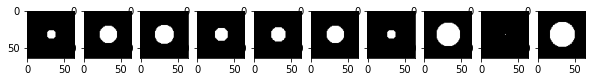

In [3]:
data = dataset.construct(nsamples, nrows, ncols, "circle")

fig, axs = plt.subplots(1, 10, figsize=(10,1))
for (i, ax) in enumerate(axs):
    ax.imshow(data[i].reshape(nrows, ncols), vmin=0, vmax=255)

X = data - data.mean(axis=0)

In [4]:
pca = PCA(n_components=ncomponents)  # use n principle components
pca.fit(X)  # fit data to PCA
eigvals, eigvecs = pca.explained_variance_, pca.components_

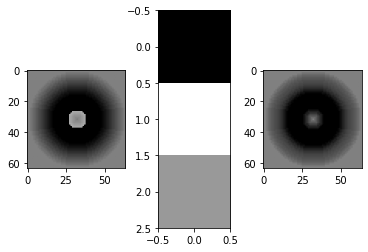

In [5]:
Z = pca.transform(X)
X_pred = pca.inverse_transform(Z)

fig, ax = plt.subplots(ncols=3, nrows=1)
ax[0].imshow(tf.reshape(X[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)
ax[1].imshow(tf.reshape(Z[expl_idx],(-1, 1)))
ax[2].imshow(tf.reshape(X_pred[expl_idx],(nrows, ncols)), vmin=vmin, vmax=vmax)

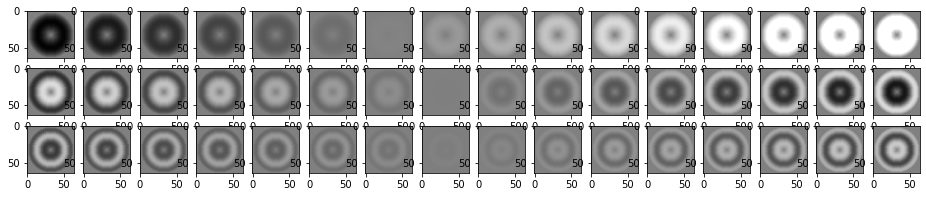

In [6]:
steps = 16
Z = pca.transform(X)
z_vars = [np.linspace(tf.reduce_min(z), tf.reduce_max(z), steps) for z in tf.transpose(Z)] # interpolation range

fig, axs = plt.subplots(ncols=steps, nrows=ncomponents, figsize=(steps, ncomponents))

for i in range(ncomponents):
    for j in range(steps):
        z = np.zeros_like(Z[expl_idx]) # only vary one component at a time, rest 0. Possible because latent features are not correlated.
        z[i] = z_vars[i][j]
        x_pred = pca.inverse_transform(z)
        ax = list(axs.flat)[j+i*j] if ncomponents==1 else axs[i, j]
        ax.imshow(x_pred.reshape(nrows, ncols), vmin=vmin, vmax=vmax)

PCA using Eigendecomposition yields different principle components than sklearn's PCA implementation (uses SVD). Thus there is more than one unique set of basis vectors optimally describing the data.

In [7]:
pca = PCA(n_components=ncomponents)
pca.fit(X)

cov = (tf.transpose(X) @ X) / (nsamples-1)
eval, evec = eigh(cov)
eval, evec = eval[::-1], evec[:, ::-1]
tot_var = eval.sum()

print("---Eigendecomposition---")
print("Shape:\n", evec[:ncomponents].shape)
print("Eigenvalues (explained variance):\n", np.round( eval[:ncomponents], 3) )
print("Eigenvalue/tot_var (explained variance percentage):\n", np.round( eval[:ncomponents]/tot_var, 3) )
print("Eigenvectors:\n", np.round( evec[:ncomponents], 3) )

print("---sklearn PCA---")
print("Shape:\n", pca.components_.shape)
print("Eigenvalues (explained variance):\n", np.round( pca.explained_variance_, 3) )
print("Eigenvalue/tot_var (explained variance percentage):\n", np.round( pca.explained_variance_ratio_, 3) )
print("Eigenvectors:\n", np.round( pca.components_, 3), "\n")

print("Eigendecomposition seems to favor unit vectors with a single component of length 1.\n"
    "SVD (sklearn) finds more `composed` vectors (of unit length).")

---Eigendecomposition---
Shape:
 (3, 4096)
Eigenvalues (explained variance):
 [21129222.   4968307.5  2155950. ]
Eigenvalue/tot_var (explained variance percentage):
 [0.632 0.148 0.064]
Eigenvectors:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
---sklearn PCA---
Shape:
 (3, 4096)
Eigenvalues (explained variance):
 [21129196.   4968276.   2155974.5]
Eigenvalue/tot_var (explained variance percentage):
 [0.632 0.148 0.064]
Eigenvectors:
 [[ 0.  0.  0. ... -0. -0. -0.]
 [-0.  0. -0. ... -0. -0. -0.]
 [-0.  0. -0. ...  0.  0.  0.]] 

Eigendecomposition seems to favor unit vectors with a single component of length 1.
SVD (sklearn) finds more `composed` vectors (of unit length).


Dot product of all PC axes permutations:
 [[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]
===> Identity: unit norm & dot product between off-diagonal axis 90deg (orthogonal).

tf.Tensor(
[[ 2.1129208e+07 -4.4444447e+00  2.4766476e+00]
 [-4.4444447e+00  4.9682775e+06  1.6673667e+00]
 [ 2.4766476e+00  1.6673667e+00  2.1559705e+06]], shape=(3, 3), dtype=float32)
===> (Mostly) uncorrelated latent activation. Off-diagonal elements are a bit different to 01_PCA.


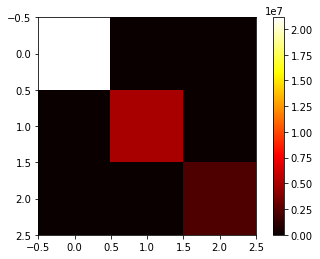

In [8]:
pcs = pca.components_

I = pcs @ pcs.T
print("Dot product of all PC axes permutations:\n", np.round(I, 5))
print("===> Identity: unit norm & dot product between off-diagonal axis 90deg (orthogonal).\n")

Z = X @ pcs.T
Z = tf.subtract(Z, tf.reduce_mean(Z,axis=0))
Z_cov = (tf.transpose(Z) @ Z) / (nsamples - 1)
print(Z_cov)
plt.imshow(Z_cov, cmap='hot')
plt.colorbar()
print("===> (Mostly) uncorrelated latent activation. Off-diagonal elements are a bit different to 01_PCA.")

In [9]:
X_pred = pca.inverse_transform(Z)
np.square(np.subtract(X, X_pred)).mean()

1270.472